### Limit Scope to Only AGR Testing, No Sockets, No Implementation, Just Logits Aggregation

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.datasets as datasets
from scipy.stats import norm
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Stats
class RunningStats:
    """
    Tracks running mean and covariance of vectors in R^C
    using online (streaming) updates.

    This is purely observational — no modification of inputs.
    """

    def __init__(self, dim, device="cpu", eps=1e-6):
        self.dim = dim
        self.device = device
        self.eps = eps

        self.n = 0
        self.mean = torch.zeros(dim, device=device)
        self.M2 = torch.zeros(dim, dim, device=device)  # sum of outer products

    @torch.no_grad()
    def update(self, x):
        """
        x: Tensor of shape (C,)
        """
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += torch.outer(delta, delta2)

    def covariance(self):
        if self.n < 2:
            return torch.eye(self.dim, device=self.device) * self.eps
        return self.M2 / (self.n - 1) + self.eps * torch.eye(self.dim, device=self.device)

    def principal_eigensystem(self):
        Sigma = self.covariance()
        eigvals, eigvecs = torch.linalg.eigh(Sigma)
        return eigvals[-1], eigvecs[:, -1]

    def std(self):
        """Per-class std (shape: C)"""
        return torch.sqrt(torch.diag(self.covariance()))


class PublicPredictionObserver:
    """
    Observes public predictions over rounds and maintains
    per-sample statistics if desired.
    """

    def __init__(self, num_classes, device="cpu"):
        self.num_classes = num_classes
        self.device = device
        self.stats = None

    def reset(self):
        self.stats = None

    @torch.no_grad()
    def observe(self, predictions):
        """
        predictions: Tensor of shape (N, C)
        """
        N, C = predictions.shape
        assert C == self.num_classes

        if self.stats is None:
            self.stats = [
                RunningStats(C, device=self.device)
                for _ in range(N)
            ]

        for i in range(N):
            self.stats[i].update(predictions[i])

    def mean(self):
        return torch.stack([s.mean for s in self.stats])
    
    def std(self):
        return torch.stack([s.std() for s in self.stats])
    
    def covariance(self, idx):
        """
        Covariance for a specific public sample
        """
        return self.stats[idx].covariance()

    def dominant_direction(self, idx):
        return self.stats[idx].principal_eigensystem()

    
def inv_phi(n):
    if not (0.0 < n < 1.0):
        raise ValueError("n must be in (0, 1)")
    return norm.ppf(n)


In [3]:
# BENIGN CLIENT
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 256)
        self.lin2 = nn.Linear(256, 64)
        self.lin3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        return self.lin3(x)

In [4]:
# MALICIOUS CLIENT
class LIE_Model(nn.Module):
    def __init__(self, active_round, num_malicious, num_models, observer):
        super().__init__()
        self.lin1 = nn.Linear(784, 256)
        self.lin2 = nn.Linear(256, 64)
        self.lin3 = nn.Linear(64, 10)
        self.active_round = active_round
        self.num_rounds = 0
        self.observer = observer
        self.num_malicious = num_malicious
        self.num_models= num_models

    def calculate_v(self):
        z_max = inv_phi(1-(self.num_malicious/self.num_models))
        return self.observer.mean() + z_max

    def forward(self, x):
        if not self.training and self.num_rounds > self.active_round:
            return self.calculate_v()
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        return self.lin3(x)

In [5]:
def train_ce_fullbatch(model, X, y, optimizer, epochs):
    model.train()
    for _ in range(epochs):
        optimizer.zero_grad()
        logits = model(X)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()

def train_distill_fullbatch(model, X_pub, teacher_probs, optimizer, epochs, lam = 1, eps=1e-12):
    """
    Distill using teacher probability vectors (Cronus shares prediction vectors).
    Minimize KL(teacher || student) equivalent to cross-entropy with soft targets.
    """
    model.train()
    for _ in range(epochs):
        optimizer.zero_grad()
        student_logits = model(X_pub)
        student_log_probs = F.log_softmax(student_logits, dim=1)
        # KLDivLoss expects log-probs input and probs target
        loss = lam * F.kl_div(student_log_probs, teacher_probs.clamp_min(eps), reduction="batchmean")
        loss.backward()
        optimizer.step()

@torch.no_grad()
def predict_probs(model, X):
    model.eval()
    probs = F.softmax(model(X), dim=1)
    return probs

In [6]:
# -----------------------------
# Median Aggregation
# - Simple median of logit predictions
# - Used as a baseline
# -----------------------------
def f_median(logits):

    mu = logits.median(dim=0).values

    return mu

# -----------------------------
# Mean Aggregation
# - Simple mean of logit predictions
# - Used as a baseline
# -----------------------------
def f_mean(logits):

    mu = logits.mean(dim=0)

    return mu

# -----------------------------
# RobustFilter Aggregation
# - Trims logits
# -----------------------------
def f_cronus(
    logits,
    eps=1e-3,
    lambda_thresh=9.0,
    max_iters=5
):
    """
    Robust Cronus aggregation.

    logits: Tensor [K, N, C]  (models × samples × classes)
    returns: Tensor [N, C]
    """

    K, N, C = logits.shape
    device = logits.device

    agg = torch.zeros(N, C, device=device)

    for n in range(N):

        # Y: [K, C] logits for sample n
        Y = logits[:, n, :]

        # Initial mean
        mu = Y.mean(dim=0)

        for _ in range(max_iters):

            # Centered data
            X = Y - mu

            # If no disagreement, stop
            if X.norm() < 1e-6:
                break

            # Empirical covariance (rank-deficient-safe)
            Sigma = (X.T @ X) / max(len(Y) - 1, 1)

            # Diagonal regularization
            Sigma = Sigma + eps * torch.eye(C, device=device)

            # Eigendecomposition with safety
            try:
                eigvals, eigvecs = torch.linalg.eigh(Sigma)
            except RuntimeError:
                # Covariance too ill-conditioned → skip trimming
                break

            lambda_star = eigvals[-1]

            # If largest eigenvalue small enough, stop trimming
            if lambda_star <= lambda_thresh:
                break

            # Principal direction
            v_star = eigvecs[:, -1]

            # Project samples onto principal direction
            projections = torch.abs((Y - mu) @ v_star)

            max_proj = projections.max()
            if max_proj < 1e-6:
                break

            # Randomized trimming threshold (Cronus)
            T = torch.sqrt(torch.rand(1, device=device)) * max_proj

            mask = projections < T

            # If too few samples left, stop
            if mask.sum() <= 1:
                break

            # Trim and recompute mean
            Y = Y[mask]
            mu = Y.mean(dim=0)

        agg[n] = mu

    return agg

def f_trimmed_mean(
    logits,
    beta=0.2
):
    """
    Coordinate-wise trimmed mean aggregation.

    logits: Tensor [K, N, C]  (models × samples × classes)
    beta: fraction to trim from each side (0 < beta < 0.5)

    returns: Tensor [N, C]
    """

    K, N, C = logits.shape
    device = logits.device

    # Number to trim on each side
    t = int(beta * K)
    if 2 * t >= K:
        raise ValueError("beta too large: removes all samples")

    agg = torch.zeros(N, C, device=device)

    for n in range(N):
        # Y: [K, C] logits for sample n
        Y = logits[:, n, :]  # (K, C)

        # Sort per coordinate
        Y_sorted, _ = torch.sort(Y, dim=0)  # (K, C)

        # Trim extremes
        Y_trimmed = Y_sorted[t:K - t, :]  # (K - 2t, C)

        # Mean of remaining values
        agg[n] = Y_trimmed.mean(dim=0)

    return agg

def f_cronus_trimmed(
    logits,
    eps=1e-3,
    lambda_thresh=9.0,
    max_iters=5,
    trim_frac=0.2
):
    """
    Hybrid Cronus + coordinate-wise trimmed mean aggregation.

    logits: Tensor [K, N, C]  (models × samples × classes)
    trim_frac: fraction to trim in coordinate-wise step
    returns: Tensor [N, C]
    """
    K, N, C = logits.shape
    device = logits.device
    agg = torch.zeros(N, C, device=device)

    for n in range(N):
        # Step 1: take logits for this sample
        Y = logits[:, n, :]

        # --- Directional trimming (Cronus) ---
        mu = Y.mean(dim=0)
        for _ in range(max_iters):
            X = Y - mu
            if X.norm() < 1e-6:
                break

            Sigma = (X.T @ X) / max(len(Y)-1, 1)
            Sigma = Sigma + eps * torch.eye(C, device=device)

            try:
                eigvals, eigvecs = torch.linalg.eigh(Sigma)
            except RuntimeError:
                break

            lambda_star = eigvals[-1]
            if lambda_star <= lambda_thresh:
                break

            v_star = eigvecs[:, -1]
            projections = torch.abs((Y - mu) @ v_star)
            max_proj = projections.max()
            if max_proj < 1e-6:
                break

            T = torch.sqrt(torch.rand(1, device=device)) * max_proj
            mask = projections < T
            if mask.sum() <= 1:
                break

            Y = Y[mask]
            mu = Y.mean(dim=0)

        # --- Coordinate-wise trimming ---
        K_remaining = Y.shape[0]
        if K_remaining > 1:
            lower_idx = int(K_remaining * trim_frac)
            upper_idx = K_remaining - lower_idx

            Y_sorted, _ = torch.sort(Y, dim=0)
            Y = Y_sorted[lower_idx:upper_idx, :]  # trim top/bottom

        # --- Aggregate ---
        agg[n] = Y.mean(dim=0)

    return agg

# =============================
# Geometric Median
# =============================
def geometric_median(Y, eps=1e-5, max_iters=10):
    """
    Computes the geometric median of vectors Y ∈ R^(K × C) using Weiszfeld's algorithm.
    """
    device = Y.device
    mu = Y.mean(dim=0)  # initial guess

    for _ in range(max_iters):
        diff = Y - mu  # (K, C)
        dist = torch.clamp(diff.norm(dim=1), min=1e-12)
        weights = 1.0 / dist
        mu_new = (weights[:, None] * Y).sum(dim=0) / weights.sum()
        if (mu_new - mu).norm() < eps:
            break
        mu = mu_new

    return mu

# -----------------------------
# Cronus + Geometric Median Aggregation
# -----------------------------
def f_cronus_geommedian(
    logits,
    eps=1e-3,
    lambda_thresh=9.0,
    max_iters=5,
):
    """
    Hybrid Cronus + geometric median aggregation.

    logits: Tensor [K, N, C]  (models × samples × classes)
    returns: Tensor [N, C]
    """
    K, N, C = logits.shape
    device = logits.device
    agg = torch.zeros(N, C, device=device)

    for n in range(N):
        Y = logits[:, n, :]  # logits for sample n

        # --- Cronus directional trimming ---
        mu = Y.mean(dim=0)
        for _ in range(max_iters):
            X = Y - mu
            if X.norm() < 1e-6:
                break

            Sigma = (X.T @ X) / max(len(Y)-1, 1)
            Sigma = Sigma + eps * torch.eye(C, device=device)

            try:
                eigvals, eigvecs = torch.linalg.eigh(Sigma)
            except RuntimeError:
                break

            lambda_star = eigvals[-1]
            if lambda_star <= lambda_thresh:
                break

            v_star = eigvecs[:, -1]
            projections = torch.abs((Y - mu) @ v_star)
            max_proj = projections.max()
            if max_proj < 1e-6:
                break

            T = torch.sqrt(torch.rand(1, device=device)) * max_proj
            mask = projections < T
            if mask.sum() <= 1:
                break

            Y = Y[mask]
            mu = Y.mean(dim=0)

        # --- Aggregate with geometric median ---
        agg[n] = geometric_median(Y)

    return agg

In [7]:
# =============================
# BiLA-CM Aggregation Model
# =============================
class BilaModel(nn.Module):
    def __init__(self, initLabels, lr=0.001, decay=0.5,
                 t=1, hidden_layers=64, eps=1e-6):
        """
        BiLA-CM label aggregation model.
        initLabels: Tensor [K, N, C] initial labels from K models
        """
        super().__init__()
        self.lr = lr
        self.decay = decay
        self.t = t

        # Dimensions
        K, N, C = initLabels.shape

        # α: label correction network
        self.W1 = nn.Linear(K * C, hidden_layers)
        self.W2 = nn.Linear(hidden_layers, C)

        # β: full confusion tensor (C × K × C)
        w_init = torch.zeros(C, K, C)
        for c in range(C):
            for k in range(K):
                w_init[c, k] = initLabels[k].mean(dim=0)

        w_init = w_init / (w_init.sum(dim=2, keepdim=True) + eps)
        self.w = nn.Parameter(w_init)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

    # -----------------------------
    # Training & Aggregation
    # -----------------------------
    def UpdateAndAggregate(self, labels):
        """
        labels: Tensor [K, N, C]
        returns: Tensor [N, C] aggregated soft labels
        """
        K, N, C = labels.shape
        device = labels.device

        for epoch in range(self.t):
            psi = torch.softmax(self.w, dim=2)   # (C, K, C)
            total_loss = 0.0

            for n in range(N):
                label = labels[:, n, :]            # (K, C)
                label_flat = label.reshape(-1)     # (K*C)

                # q_alpha(y | l_i)
                h = self.W2(torch.tanh(self.W1(label_flat)))  # (C,)
                q_alpha = torch.softmax(h, dim=0)             # (C,)

                # log g_beta(l_i | y=c)
                l_idx = label.argmax(dim=1)        # (K,)
                psi_ck_li = psi[:, torch.arange(K), l_idx]   # (C, K)
                log_g_beta = torch.log(psi_ck_li + 1e-9).sum(dim=1)  # (C,)

                # loss
                loss_n = torch.sum(q_alpha * (torch.log(q_alpha + 1e-9) + log_g_beta))
                total_loss -= loss_n

            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()

        # ---- aggregation ----
        psi = torch.softmax(self.w, dim=2)        # (C, K, C)
        c_idx = torch.arange(C, device=psi.device)
        pi = psi[c_idx, :, c_idx]                 # (C, K)
        labels_perm = labels.permute(2, 0, 1)     # (C, K, N)
        scores = (pi.unsqueeze(2) * labels_perm).sum(dim=1)  # (C, N)
        agg_labels = torch.softmax(scores.T, dim=1)           # (N, C)

        return agg_labels


# =============================
# Utilities
# =============================
@torch.no_grad()
def predict_logits(model, X):
    """
    Returns logits from a model.
    """
    model.eval()
    return model(X)

In [37]:
# Data Initialization
observer = PublicPredictionObserver(num_classes=10, device=device)

mnist_train = datasets.MNIST(root="./data", train=True, download=True)
mnist_test  = datasets.MNIST(root="./data", train=False, download=True)

X_train = mnist_train.data[:50000].float().flatten(1).to(device)
Y_train = mnist_train.targets[:50000].to(device)

X_pub = mnist_train.data[50000:].float().flatten(1).to(device)
Y_pub = mnist_train.targets[50000:].to(device)

X_test = mnist_test.data.float().flatten(1).to(device)
Y_test = mnist_test.targets.to(device)

NUM_PARTIES = 20       
T1 = 50           
T2 = 50             
eps_adv = 0.1           
lambda_thresh = 9.0 
agg_iters = 2   
NUM_LIE = 0
NUM_LABEL_FLIP = 0
LABEL_FLIP_TARGET = 5

if NUM_LIE > 0 and NUM_LABEL_FLIP > 0:
    raise Exception("Cannot have LIE and Label Flip attacks at the same time")
     
# Split private data across parties (simple IID split)
per_party = len(X_train) // NUM_PARTIES
perm = torch.randperm(len(X_train), device=device)

X_parts = []
Y_parts = []
for i in range(NUM_PARTIES):
    idx = perm[i * per_party : (i + 1) * per_party]
    X_parts.append(X_train[idx])
    Y_parts.append(Y_train[idx])

if NUM_LABEL_FLIP > 0:
    for i in range(NUM_LABEL_FLIP):
        Y_parts[i][:] = LABEL_FLIP_TARGET 

if NUM_LIE > 0:
    models = [LIE_Model(active_round=5, num_malicious=NUM_LIE, num_models=NUM_PARTIES, observer=observer).to(device) for _ in range(0,NUM_LIE)]
    models = models + [MnistModel().to(device) for _ in range(NUM_LIE,NUM_PARTIES)]
else:
    models =  [MnistModel().to(device) for _ in range(NUM_LIE,NUM_PARTIES)]
    

In [38]:
# Wrapper function to run cronus
def run_cronus(aggregator):

    # --- Initialization phase (private-only, Adam lr=0.0005) :contentReference[oaicite:11]{index=11}
    for i in range(NUM_PARTIES):
        opt = Adam(models[i].parameters(), lr=5e-4)
        train_ce_fullbatch(models[i], X_parts[i], Y_parts[i], opt, epochs=T1)
    
    # Initial predictions on public set (Y^0_i = PREDICT(theta_i; Xp)) :contentReference[oaicite:12]{index=12}
    with torch.no_grad():
        probs_stack = torch.stack([predict_probs(m, X_pub) for m in models], dim=0)  # (K,N,C)
    Y_bar = aggregator(probs_stack)
    #Y_bar = f_cronus_geommedian(probs_stack)
    observer.observe(Y_bar)
    
    # =============================
    # Collaboration Phase
    # =============================
    public_err = []
    model_err = []
    
    # Create an optimizer for each model (SGD on public + Adam on private if needed)
    opts = [torch.optim.SGD(models[i].parameters(), lr=1e-3) for i in range(NUM_PARTIES)]
    
    for t in range(T2):
        # -----------------------------
        # Each party trains on private + public data
        # -----------------------------
        for i in range(NUM_PARTIES):
            # Train on private data
            train_ce_fullbatch(models[i], X_parts[i], Y_parts[i], opts[i], epochs=1)
            # Knowledge distillation / public data
            train_distill_fullbatch(models[i], X_pub, Y_bar.detach(), opts[i], epochs=1)
    
        # -----------------------------
        # Server Aggregation on public data
        # -----------------------------
        with torch.no_grad():
            # Collect logits from all models
            logits_stack = torch.stack([predict_logits(m, X_pub) for m in models], dim=0)  # (K, N, C)
            # Convert to probabilities
            probs_stack = F.softmax(logits_stack, dim=-1)
            # Aggregate using Cronus (or Geometric Median if you prefer)
            #Y_bar = f_cronus_geommedian(probs_stack, eps=eps_adv, lambda_thresh=lambda_thresh)
            Y_bar = aggregator(probs_stack)
            # Observe current aggregation (for monitoring)
            observer.observe(Y_bar)
    
        # -----------------------------
        # Logging public error
        # -----------------------------
        with torch.no_grad():
            cronus_preds = Y_bar.argmax(dim=1)
            cronus_err = (cronus_preds != Y_pub).float().mean().item()
            print(f"[Cronus] epoch {t:02d} | public error {cronus_err:.4f}")
        
        # -----------------------------
        # Logging model error
        # -----------------------------
        errs = []
        for i in range(NUM_PARTIES):
            preds = models[i](X_test).argmax(dim=1)
            err = (preds != Y_test).float().mean().item()
            print(f"Collab epoch {t:02d}, party {i}, error {err:.4f}")
            errs.append(err)
    
        # -----------------------------
        # Update malicious/lying models rounds
        # -----------------------------
        for model in models[:NUM_LIE]:
            model.num_rounds += 1
    
        # -----------------------------
        # Record metrics
        # -----------------------------
        public_err.append(cronus_err)
        model_err.append(errs)
    
    print("Finished Collaboration Phase")

    public_err = np.array(public_err)
    model_err = np.array(model_err)

    return public_err, model_err

aggregators = [f_cronus, f_trimmed_mean, f_cronus_trimmed, geometric_median, f_cronus_geommedian]
aggregator_names = ["Original RobustFilter", "Trimmed Mean", "RobustFilter+Trimmed Mean", "Geometric Median", "RobustFilter+Geometric Median"]

aggregator_errs = []
model_errs = []

for i in range(len(aggregators)):

    print(f"Running Cronus With {aggregator_names[i]} Aggregator")
    aggregator_err, model_err = run_cronus(aggregators[i])

    aggregator_errs.append(aggregator_err)
    model_errs.append(model_err)


Running Cronus With Original RobustFilter Aggregator
[Cronus] epoch 00 | public error 0.0555
Collab epoch 00, party 0, error 0.1055
Collab epoch 00, party 1, error 0.1060
Collab epoch 00, party 2, error 0.1049
Collab epoch 00, party 3, error 0.1064
Collab epoch 00, party 4, error 0.1113
Collab epoch 00, party 5, error 0.1194
Collab epoch 00, party 6, error 0.1333
Collab epoch 00, party 7, error 0.1184
Collab epoch 00, party 8, error 0.1020
Collab epoch 00, party 9, error 0.1041
Collab epoch 00, party 10, error 0.0991
Collab epoch 00, party 11, error 0.1067
Collab epoch 00, party 12, error 0.1109
Collab epoch 00, party 13, error 0.1098
Collab epoch 00, party 14, error 0.1074
Collab epoch 00, party 15, error 0.1085
Collab epoch 00, party 16, error 0.1035
Collab epoch 00, party 17, error 0.1068
Collab epoch 00, party 18, error 0.1117
Collab epoch 00, party 19, error 0.1043
[Cronus] epoch 01 | public error 0.0555
Collab epoch 01, party 0, error 0.1052
Collab epoch 01, party 1, error 0.1056

Aggregated Label Errors
Original RobustFilter: 0.05419999733567238
Trimmed Mean: 0.043299999088048935
RobustFilter+Trimmed Mean: 0.04209999740123749
Geometric Median: 0.04050000011920929
RobustFilter+Geometric Median: 0.03959999978542328


Model Avg Errors
Original RobustFilter: 0.10465499684214592
Trimmed Mean: 0.07566999904811382
RobustFilter+Trimmed Mean: 0.07073499858379365
Geometric Median: 0.07183999791741372
RobustFilter+Geometric Median: 0.06754499897360802


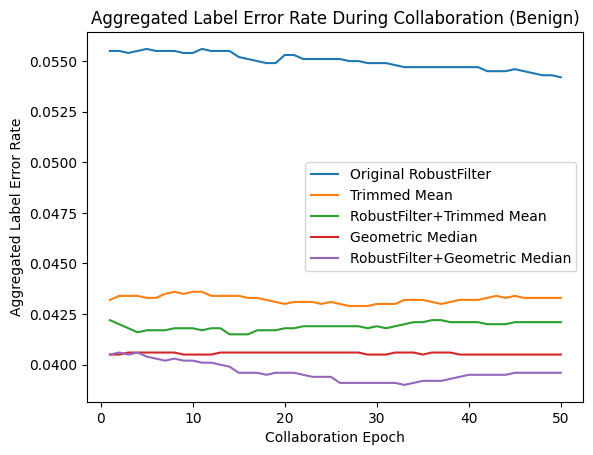

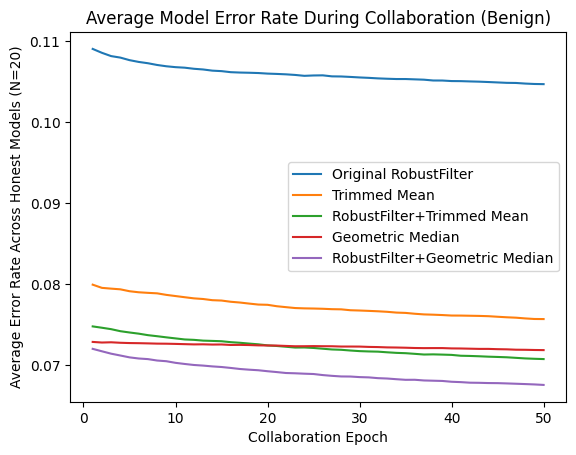

In [40]:
import matplotlib.pyplot as plt

aggregator_names = ["Original RobustFilter", "Trimmed Mean", "RobustFilter+Trimmed Mean", "Geometric Median", "RobustFilter+Geometric Median"]

# Plotting data and graphs

plt.figure(1)
plt.title("Aggregated Label Error Rate During Collaboration (Benign)")
plt.xlabel("Collaboration Epoch")
plt.ylabel("Aggregated Label Error Rate")

print("Aggregated Label Errors")
for i in range(len(aggregators)):
    plt.plot(range(1,51), aggregator_errs[i], label=f"{aggregator_names[i]}")
    print(f"{aggregator_names[i]}: {aggregator_errs[i][-1]}")
plt.legend()
plt.savefig("agg_label_error.png")

print("\n")

plt.figure(2)
plt.title("Average Model Error Rate During Collaboration (Benign)")
plt.xlabel("Collaboration Epoch")
plt.ylabel(f"Average Error Rate Across Honest Models (N={NUM_PARTIES - NUM_LIE - NUM_LABEL_FLIP})")

print("Model Avg Errors")
for i in range(len(aggregators)):
    avg_err = np.mean(model_errs[i][:,NUM_LABEL_FLIP:], axis=1)
    plt.plot(range(1,51), avg_err, label=f"{aggregator_names[i]}")
    print(f"{aggregator_names[i]}: {avg_err[-1]}")
    
plt.legend()
plt.savefig("model_error.png")


In [ ]:
# --- Initialization phase with bila (private-only, Adam lr=0.0005) :contentReference[oaicite:11]{index=11}
for i in range(NUM_PARTIES):
    opt = Adam(models[i].parameters(), lr=5e-4)
    train_ce_fullbatch(models[i], X_parts[i], Y_parts[i], opt, epochs=T1)

# Initial predictions on public set (Y^0_i = PREDICT(theta_i; Xp)) :contentReference[oaicite:12]{index=12}
with torch.no_grad():
    probs_stack = torch.stack([predict_probs(m, X_pub) for m in models], dim=0)  # (K,N,C)
bilaAggregator = BilaModel(probs_stack).to(device)
Y_bar = bilaAggregator.UpdateAndAggregate(probs_stack)
observer.observe(Y_bar)

In [ ]:
# --- Collaboration phase (with bila)

opts = []
for i in range(NUM_PARTIES):
    # Create an SGD optimizer for each model
    opts.append(SGD(models[i].parameters(), lr=1e-3))

for t in range(T2):
    # Each party updates on Di ∪ Dp (paper does private Adam + public SGD) :contentReference[oaicite:13]{index=13}
    for i in range(NUM_PARTIES):
        train_ce_fullbatch(models[i], X_parts[i], Y_parts[i], opts[i], epochs=1)
        train_distill_fullbatch(models[i], X_pub, Y_bar.detach(), opts[i], epochs=1)

    # Parties send prediction vectors on Xp; server aggregates to Y_bar^{t+1}
    with torch.no_grad():
        probs_stack = torch.stack([predict_probs(m, X_pub) for m in models], dim=0)

    Y_bar = bilaAggregator.UpdateAndAggregate(probs_stack)

    observer.observe(Y_bar)

    # Logging
    with torch.no_grad():
        for i in range(NUM_PARTIES):
            preds = models[i](X_test).argmax(dim=1)
            err = (preds != Y_test).float().mean().item()
            print(f"Collab epoch {t:02d}, party {i}, error {err:.4f}")

    for model in models[0:NUM_MALICIOUS]:
        model.num_rounds+=1 

print("Finished")